## Data Preprocessing

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import folium
#import movingpandas as mpd
from shapely.geometry import Point
import numpy as np
import os
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

In [2]:
file_path = r"C:\Users\slab\Desktop\Slab Project\Stage2 ETA\Raw Data\477769500_VesselHistoryLineInfo.csv"
try:
    df
except NameError:
    df = pd.read_csv(file_path, low_memory=False)
df = pd.read_csv(file_path, low_memory=False)

# 我只想畫出477769500這艘船的航線圖，先把其他的洗掉
mmsi_target = 477769500
df_filtered = df[df['MMSI'] == mmsi_target].copy()
print(len(df_filtered))
print(df_filtered.head())

264586
      Pky      IMO       MMSI CallSign  FacNumber ShipName_CH ShipName_ENG  \
0  378737  9322736  477769500  VRPK2@@        NaN         豐順輪    FENG SHUN   
1  378738  9322736  477769500  VRPK2@@        NaN         豐順輪    FENG SHUN   
2  378741  9322736  477769500  VRPK2@@        NaN         豐順輪    FENG SHUN   
3  378742  9322736  477769500  VRPK2@@        NaN         豐順輪    FENG SHUN   
4  378744  9322736  477769500  VRPK2@@        NaN         豐順輪    FENG SHUN   

   VesselLine VesselType  VesselSeries  ...  IsDel           CreateTime  \
0         NaN        散裝輪           NaN  ...      1  2025/09/15 11:40:19   
1         NaN        散裝輪           NaN  ...      1  2025/09/15 11:42:19   
2         NaN        散裝輪           NaN  ...      1  2025/09/15 11:48:19   
3         NaN        散裝輪           NaN  ...      1  2025/09/15 11:50:19   
4         NaN        散裝輪           NaN  ...      1  2025/09/15 11:54:19   

   LastUpdateUserID       LastUpdateTime      LastUpdatePage  B_Rudder  \

In [3]:
df_filtered = df_filtered[
    (df_filtered['Lat'] >= -90) & (df_filtered['Lat'] <= 90) &
    (df_filtered['Lng'] >= -180) & (df_filtered['Lng'] <= 180)
].copy()

# 再檢查經緯度是否都合理
print(df_filtered[['Lat', 'Lng']].describe())

                 Lat            Lng
count  263812.000000  263812.000000
mean       26.857002     123.005259
std         3.074700       5.045676
min        25.029188     119.479290
25%        25.155197     120.273480
50%        25.507810     121.389634
75%        26.133184     121.391440
max        36.123352     139.860230


In [4]:
df_filtered['Lat'] = df_filtered['Lat'].astype(float)
df_filtered['Lng'] = df_filtered['Lng'].astype(float)
df_filtered['Heading'] = df_filtered['Heading'].astype(float)
df_filtered['CreateTime'] = pd.to_datetime(df_filtered['CreateTime'], errors='coerce')
df_filtered = df_filtered.dropna(subset=['Lat', 'Lng', 'CreateTime'])

# 為了不讓圖片上線斷掉，將經度[-180, 180] 轉成 [0, 360]
df_filtered['Lng_360'] = df_filtered['Lng'] % 360

# 計算地圖中心
map_center_lat = df_filtered['Lat'].mean()
map_center_lon = df_filtered['Lng_360'].mean()

# 設定時間閾值
threshold = pd.to_datetime("2025-07-25 10:58:10")

# 條件更新 Sog 欄位
df_filtered.loc[df_filtered['CreateTime'] > threshold, 'Sog'] = (
    df_filtered.loc[df_filtered['CreateTime'] > threshold, 'Sog'] / 10
)

df_filtered = df_filtered.sort_values('CreateTime').reset_index(drop=True)

In [5]:
# 計算相鄰時間差 (秒)
df_filtered['time_diff'] = df_filtered['CreateTime'].diff().dt.total_seconds()

# 檢查異常間隔
print(df_filtered['time_diff'].describe())

count    263811.000000
mean         84.368184
std         157.713366
min           0.000000
25%           0.000000
50%           0.000000
75%         120.000000
max       48120.000000
Name: time_diff, dtype: float64


## Feature Engineering

In [6]:
import numpy as np
import pandas as pd
from haversine import haversine

# -----------------------------------
# 確保時間排序
# -----------------------------------
df_filtered = df_filtered.sort_values('CreateTime').reset_index(drop=True)

# -----------------------------------
# 計算經緯度差分
# -----------------------------------
df_filtered['Delta_Lat'] = df_filtered['Lat'].diff().abs()
df_filtered['Delta_Long'] = df_filtered['Lng_360'].diff().abs()

# 計算時間差（秒）
df_filtered['Delta_Time'] = df_filtered['CreateTime'].diff().dt.total_seconds()

# -----------------------------------
# 閾值設定
# -----------------------------------
short_time_thresh = 1.0   # 秒
sog_threshold = 0.5       # knots
rate_threshold = 0.0001   # 經緯度變化閾值

# 修正 delta 經緯度
df_filtered['Adj_Delta_Lat'] = np.where(
    df_filtered['Delta_Time'] > short_time_thresh,
    df_filtered['Delta_Lat'] / df_filtered['Delta_Time'],
    df_filtered['Delta_Lat']
)
df_filtered['Adj_Delta_Long'] = np.where(
    df_filtered['Delta_Time'] > short_time_thresh,
    df_filtered['Delta_Long'] / df_filtered['Delta_Time'],
    df_filtered['Delta_Long']
)

# -----------------------------------
# 停泊判斷
# -----------------------------------
df_filtered['Is_Stop'] = (
    (df_filtered['Sog'] < sog_threshold) &
    (df_filtered['Adj_Delta_Lat'].abs() < rate_threshold) &
    (df_filtered['Adj_Delta_Long'].abs() < rate_threshold)
)

# -----------------------------------
# 找停泊區段（容忍短暫中斷）
# -----------------------------------
max_gap_sec = 120  # 允許 2 分鐘內 False 不切斷停泊

stop_segments = []
current_start_idx = None
last_stop_idx = None

for i in range(len(df_filtered)):
    if df_filtered.loc[i, 'Is_Stop']:
        if current_start_idx is None:
            current_start_idx = i
        last_stop_idx = i
    else:
        if current_start_idx is not None:
            gap = (df_filtered.loc[i, 'CreateTime'] - df_filtered.loc[last_stop_idx, 'CreateTime']).total_seconds()
            if gap > max_gap_sec:
                segment_idx = range(current_start_idx, last_stop_idx + 1)
                stop_segments.append(segment_idx)
                current_start_idx = None
                last_stop_idx = None

# 最後一段停泊若持續到資料尾端
if current_start_idx is not None:
    segment_idx = range(current_start_idx, last_stop_idx + 1)
    stop_segments.append(segment_idx)

# -----------------------------------
# 過濾短暫停泊 (<30分鐘)
# -----------------------------------
min_stop_sec = 1800  # 30 分鐘
filtered_segments = []
for segment in stop_segments:
    start_time = df_filtered.loc[segment[0], 'CreateTime']
    end_time = df_filtered.loc[segment[-1], 'CreateTime']
    duration = (end_time - start_time).total_seconds()
    if duration >= min_stop_sec:
        filtered_segments.append(segment)

# -----------------------------------
# 航程標註與 Real_ETA_sec
# -----------------------------------
df_filtered['voyage_id'] = np.nan
df_filtered['Real_ETA_sec'] = np.nan  # 剩餘到港時間（秒）

voyage_id = 1
for i in range(len(filtered_segments) - 1):
    # 航程 = 當前停泊區段的下一點到下一停泊區段的起點
    start_idx = filtered_segments[i][-1] + 1
    end_idx = filtered_segments[i+1][0] - 1
    if start_idx > end_idx:
        continue  # 沒有航程點就跳過

    df_filtered.loc[start_idx:end_idx, 'voyage_id'] = voyage_id

    # Real_ETA_sec = 下一停泊區段時間均值 - 當前點時間
    eta_segment = filtered_segments[i+1]
    eta_time = df_filtered.loc[eta_segment, 'CreateTime'].min()

    df_filtered.loc[start_idx:end_idx, 'Real_ETA_sec'] = (
        (eta_time - df_filtered.loc[start_idx:end_idx, 'CreateTime']).dt.total_seconds()
    )

    voyage_id += 1

# -----------------------------------
# 新增「距離目的港」與「靠港判定」
# -----------------------------------
df_filtered['dist_to_dest_km'] = np.nan
df_filtered['near_port_flag'] = np.nan

# 建立 voyage_id → 目的港座標 mapping
dest_map = {}
for v in range(1, voyage_id):
    if v < len(filtered_segments):
        seg = filtered_segments[v]  # 下一停泊
        dest_lat = df_filtered.loc[seg, 'Lat'].mean()
        dest_lon360 = df_filtered.loc[seg, 'Lng_360'].mean()
        # 把 0-360 轉 -180~180
        dest_lon = dest_lon360 if dest_lon360 <= 180 else dest_lon360 - 360
        dest_map[v] = (dest_lat, dest_lon)

# 計算距離
for idx, row in df_filtered.iterrows():
    v = row['voyage_id']
    if pd.notna(v):
        v = int(v)
        if v in dest_map:
            lat1 = row['Lat']
            lon1 = row['Lng_360']
            lon1 = lon1 if lon1 <= 180 else lon1 - 360
            lat2, lon2 = dest_map[v]
            df_filtered.at[idx, 'dist_to_dest_km'] = haversine((lat1, lon1), (lat2, lon2))

# 判定靠港 flag
df_filtered.loc[df_filtered['dist_to_dest_km'] < 1.0, 'near_port_flag'] = 1.0
df_filtered.loc[(df_filtered['dist_to_dest_km'] >= 1.0) & (df_filtered['dist_to_dest_km'] <= 5.0), 'near_port_flag'] = 0.5
df_filtered.loc[df_filtered['dist_to_dest_km'] > 5.0, 'near_port_flag'] = 0.0

# -----------------------------------
# 檢查結果
# -----------------------------------
print(df_filtered[['CreateTime','Lat','Lng_360','Sog','Is_Stop',
                   'voyage_id','Real_ETA_sec',
                   'dist_to_dest_km','near_port_flag']].head(20))


            CreateTime        Lat     Lng_360  Sog  Is_Stop  voyage_id  \
0  2025-01-01 00:00:04  25.156240  121.391365  0.0    False        NaN   
1  2025-01-01 00:00:04  25.156240  121.391365  0.0     True        NaN   
2  2025-01-01 00:05:04  25.156240  121.391365  0.0     True        NaN   
3  2025-01-01 00:05:04  25.156240  121.391365  0.0     True        NaN   
4  2025-01-01 00:10:04  25.156240  121.391365  0.0     True        NaN   
5  2025-01-01 00:10:04  25.156240  121.391365  0.0     True        NaN   
6  2025-01-01 00:15:04  25.156324  121.391426  0.0     True        NaN   
7  2025-01-01 00:15:04  25.156324  121.391426  0.0     True        NaN   
8  2025-01-01 00:20:04  25.156324  121.391426  0.0     True        NaN   
9  2025-01-01 00:20:04  25.156324  121.391426  0.0     True        NaN   
10 2025-01-01 00:25:05  25.156324  121.391426  0.0     True        NaN   
11 2025-01-01 00:25:05  25.156324  121.391426  0.0     True        NaN   
12 2025-01-01 00:30:04  25.156279  121

In [7]:
# lstm 不能有空值
# lstm 的運作是把序列轉乘張量進行乘法，如果有nan後面會全是nan
df_clean = df_filtered.dropna(subset=['Real_ETA_sec', 'dist_to_dest_km']).reset_index(drop=True)


In [8]:
len(df_filtered), len(df_clean)

(263812, 81906)

In [9]:
# 將每個航程(dataframe)放進list中，後面做序列模型用
#grouped = df_clean.groupby('voyage_id')
#sequences = [group for _, group in grouped]


In [10]:
# 將太長的voyage切成多段
# 標記 segment_id
import pandas as pd
import numpy as np

# 假設 df_filtered 已經按時間排序，且包含 voyage_id 和 Real_ETA_sec

# -----------------------------
# 1. 計算每個 voyage 長度
# -----------------------------
voyage_lengths = df_filtered['voyage_id'].value_counts()

# -----------------------------
# 2. 過濾短航程 (<10)
# -----------------------------
valid_voyages = voyage_lengths[voyage_lengths >= 10].index
df_valid = df_filtered[df_filtered['voyage_id'].isin(valid_voyages)].copy()

# -----------------------------
# 3. 初始化新的 segment_id
# -----------------------------
df_valid['segment_id'] = np.nan
segment_counter = 1

# -----------------------------
# 4. 切割航程
# -----------------------------
max_segment_len = 500

for vid in df_valid['voyage_id'].unique():
    df_v = df_valid[df_valid['voyage_id'] == vid]
    n_points = len(df_v)
    
    if n_points <= max_segment_len:
        # 不切段
        df_valid.loc[df_v.index, 'segment_id'] = segment_counter
        segment_counter += 1
    else:
        # 長航程，切段
        for start in range(0, n_points, max_segment_len):
            end = start + max_segment_len
            idx_segment = df_v.index[start:end]
            df_valid.loc[idx_segment, 'segment_id'] = segment_counter
            segment_counter += 1

# -----------------------------
# 5. 重設索引
# -----------------------------
df_segments = df_valid.reset_index(drop=True)

# -----------------------------
# 6. 檢查結果
# -----------------------------
print(df_segments[['voyage_id', 'segment_id']].head(20))
print("總共段數:", df_segments['segment_id'].nunique())


    voyage_id  segment_id
0         1.0         1.0
1         1.0         1.0
2         1.0         1.0
3         1.0         1.0
4         1.0         1.0
5         1.0         1.0
6         1.0         1.0
7         1.0         1.0
8         1.0         1.0
9         1.0         1.0
10        1.0         1.0
11        1.0         1.0
12        1.0         1.0
13        1.0         1.0
14        1.0         1.0
15        1.0         1.0
16        1.0         1.0
17        1.0         1.0
18        1.0         1.0
19        1.0         1.0
總共段數: 238


## LSTM Modeling

In [12]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, TimeDistributed, Masking
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import StandardScaler

# -----------------------------
# 1. 整理 sequences (使用 segment_id)
# -----------------------------
X_list = []
y_list = []

feature_cols = ['Lat', 'Lng_360', 'Sog', 'Heading', 'dist_to_dest_km']
scalers = {col: StandardScaler() for col in feature_cols}

# grouped by segment_id
grouped_segments = df_segments.groupby('segment_id')

for _, seq in grouped_segments:
    seq = seq.dropna(subset=['Real_ETA_sec'] + feature_cols)
    if len(seq) <= 2:
        continue  # 太短的序列跳過

    # 特徵標準化（每段序列）
    X_seq = seq[feature_cols].copy()
    for col in feature_cols:
        X_seq[col] = scalers[col].fit_transform(X_seq[[col]])

    X_list.append(X_seq.values)

    # 目標值: sequence → sequence
    y_seq = seq['Real_ETA_sec'].values
    y_list.append(y_seq.reshape(-1, 1))  # 每 timestep 對應一個 Real_ETA_sec

# -----------------------------
# 2. padding sequences
# -----------------------------
max_len = max([len(x) for x in X_list])

X_padded = pad_sequences(X_list, maxlen=max_len, dtype='float32', padding='pre', truncating='pre')
y_padded = pad_sequences(y_list, maxlen=max_len, dtype='float32', padding='pre', truncating='pre')

# reshape y_padded 為 (samples, timesteps, features=1)
y_padded = y_padded.reshape(y_padded.shape[0], y_padded.shape[1], 1)

print("X_padded shape:", X_padded.shape)  # (num_samples, timesteps, num_features)
print("y_padded shape:", y_padded.shape)  # (num_samples, timesteps, 1)

# -----------------------------
# 3. 建立 LSTM 模型
# -----------------------------
model = Sequential()
model.add(Masking(mask_value=0., input_shape=(max_len, len(feature_cols))))  # mask padding
model.add(LSTM(64, return_sequences=True))
model.add(TimeDistributed(Dense(1)))  # 每 timestep 預測 Real_ETA_sec

model.compile(optimizer='adam', loss='mse', metrics=['mae'])
model.summary()

# -----------------------------
# 4. 訓練
# -----------------------------
history = model.fit(
    X_padded, y_padded,
    epochs=20,
    batch_size=32,
    validation_split=0.2
)


X_padded shape: (238, 500, 5)
y_padded shape: (238, 500, 1)


c:\Users\slab\Desktop\Slab Project\Stage2 ETA\.venv\lib\site-packages\keras\src\layers\core\masking.py:48: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ masking (Masking)               │ (None, 500, 5)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 500, 64)        │        17,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 500, 1)         │            65 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,985 (70.25 KB)

 Trainable params: 17,985 (70.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 16s 921ms/step - loss: 17642893312.0000 - mae: 57934.0039 - val_loss: 12008107008.0000 - val_mae: 58273.6445
Epoch 2/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 373ms/step - loss: 17459392512.0000 - mae: 57933.8828 - val_loss: 12008057856.0000 - val_mae: 58273.4375
Epoch 3/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 371ms/step - loss: 17633884160.0000 - mae: 57933.5938 - val_loss: 12007941120.0000 - val_mae: 58272.9102
Epoch 4/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 368ms/step - loss: 17659224064.0000 - mae: 57932.7461 - val_loss: 12007632896.0000 - val_mae: 58271.1719
Epoch 5/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 371ms/step - loss: 17900277760.0000 - mae: 57930.9883 - val_loss: 12007291904.0000 - val_mae: 58269.2305
Epoch 6/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 372ms/step - loss: 17801664512.0000 - mae: 57929.5430 - val_loss: 12007025664.0000 - val_mae: 58267.8398
Epoch 7/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 367ms/step - loss: 17682726912.0000 - mae: 57928.3984 - val_loss: 12006806528.0000 - val_mae: 58

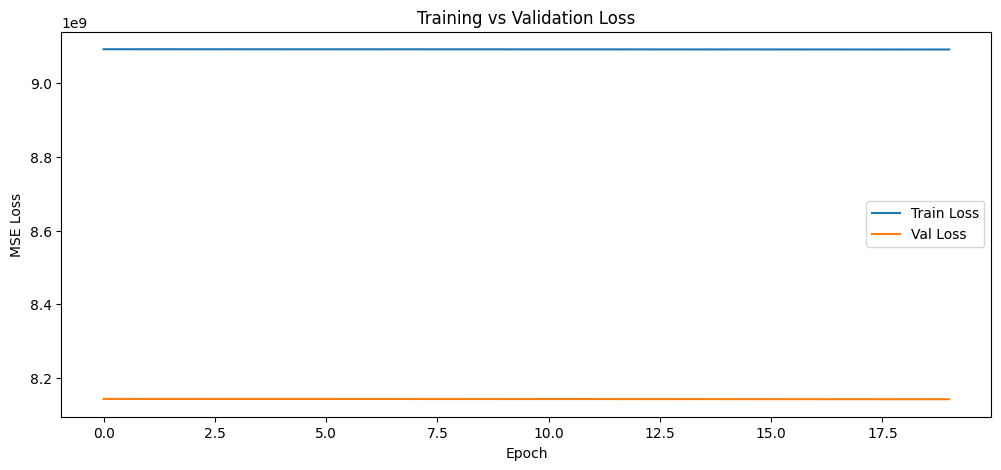

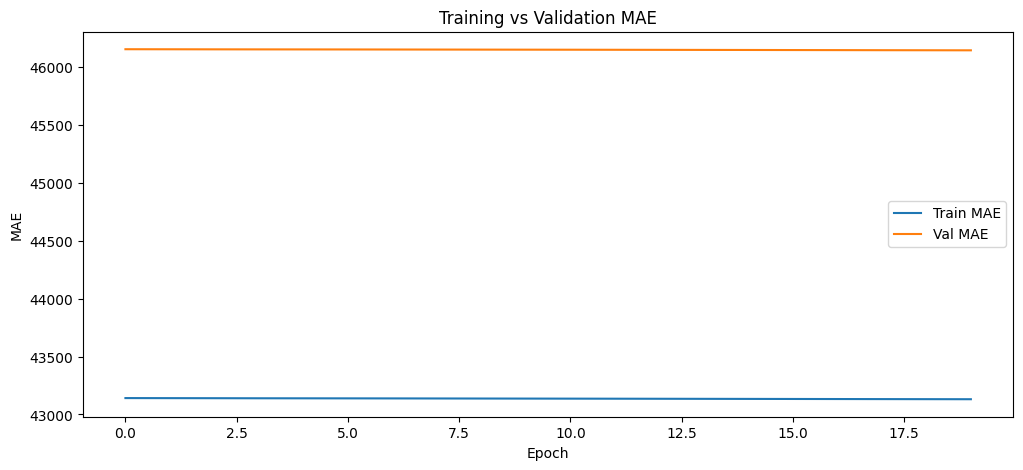

In [52]:
plt.figure(figsize=(12,5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.title('Training vs Validation Loss')
plt.show()

plt.figure(figsize=(12,5))
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Val MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()
plt.title('Training vs Validation MAE')
plt.show()


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


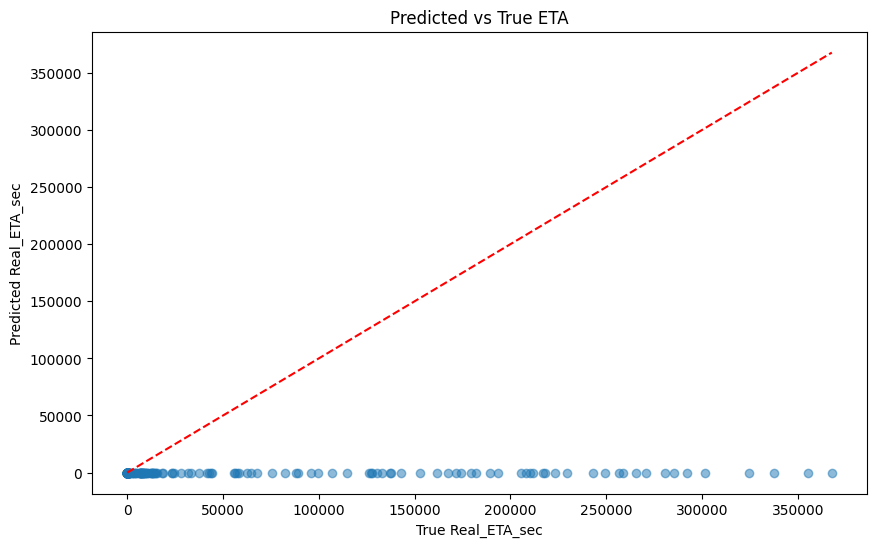

In [53]:
y_pred = model.predict(X_padded)

plt.figure(figsize=(10,6))
plt.scatter(y_array, y_pred, alpha=0.5)
plt.xlabel('True Real_ETA_sec')
plt.ylabel('Predicted Real_ETA_sec')
plt.title('Predicted vs True ETA')
plt.plot([y_array.min(), y_array.max()], [y_array.min(), y_array.max()], 'r--')
plt.show()


## 偵錯專用

In [24]:
df_filtered['voyage_id'].value_counts()

voyage_id
93.0     5876
160.0    4472
86.0     3586
158.0    3456
75.0     3454
         ... 
126.0       2
159.0       2
153.0       2
150.0       2
152.0       2
Name: count, Length: 176, dtype: int64

In [25]:
voyage_time_stats = df_clean.groupby('voyage_id').agg(
    start_time=('CreateTime', 'min'),
    end_time=('CreateTime', 'max'),
    duration_sec=('CreateTime', lambda x: (x.max() - x.min()).total_seconds()),
    mean_interval_sec=('CreateTime', lambda x: x.diff().dt.total_seconds().mean())
).reset_index()

print(voyage_time_stats)

     voyage_id          start_time            end_time  duration_sec  \
0          1.0 2025-01-01 08:10:04 2025-01-02 03:10:04       68400.0   
1          2.0 2025-01-02 04:00:04 2025-01-02 08:50:05       17401.0   
2          3.0 2025-01-02 09:45:05 2025-01-02 13:40:04       14099.0   
3          4.0 2025-01-03 10:55:05 2025-01-04 02:00:04       54299.0   
4          5.0 2025-01-04 03:20:05 2025-01-04 04:00:05        2400.0   
..         ...                 ...                 ...           ...   
171      172.0 2025-09-07 08:10:16 2025-09-07 20:00:16       42600.0   
172      173.0 2025-09-10 02:54:17 2025-09-10 15:20:17       44760.0   
173      174.0 2025-09-11 11:08:18 2025-09-11 23:32:18       44640.0   
174      175.0 2025-09-13 23:54:18 2025-09-14 08:46:24       31926.0   
175      176.0 2025-09-14 14:38:22 2025-09-14 17:44:19       11157.0   

     mean_interval_sec  
0           149.671772  
1           148.726496  
2           148.410526  
3           149.584022  
4         

In [ ]:
# 看一下Real_ETA_sec 不同的秒數
print(np.unique(y_array))
# 前20個航程的最後一個time stamp ETA 大約都是300
print(y_array[:20])

[ 19.  20.  37.  43.  83.  99. 105. 109. 111. 114. 117. 118. 119. 120.
 121. 122. 123. 124. 125. 126. 131. 134. 143. 145. 152. 166. 174. 181.
 209. 219. 231. 238. 240. 250. 254. 294. 295. 298. 299. 300. 301. 360.
 415. 446. 478. 600.]
[300. 299. 300. 300. 300. 301. 300. 300. 301. 301. 300. 300. 300. 300.
 300. 300. 300. 300. 300. 300.]


In [34]:
print(X_padded.shape)
print(X_padded[0])  # 看第一個航程的特徵是否大部分都是 0


(140, 5876, 4)
[[  0.         0.         0.         0.      ]
 [  0.         0.         0.         0.      ]
 [  0.         0.         0.         0.      ]
 ...
 [ 26.440125 120.01134    0.992218 300.      ]
 [ 26.440125 120.01134    0.992218 300.      ]
 [ 26.440125 120.01134    0.992218 300.      ]]


In [35]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Masking
from tensorflow.keras.preprocessing.sequence import pad_sequences

# -----------------------------
# 1. 生成滑動窗口序列
# -----------------------------
window_size = 50  # 每個樣本 timesteps
stride = 25       # 滑動間隔
feature_cols = ['Lat', 'Lng_360', 'Sog', 'Heading']

X_list = []
y_list = []

for seq in sequences:
    # 去掉停泊點
    seq_move = seq[seq['Is_Stop'] == False].dropna(subset=['Real_ETA_sec'] + feature_cols)
    data = seq_move[feature_cols].values
    targets = seq_move['Real_ETA_sec'].values

    if len(data) < window_size:
        continue  # 太短就跳過

    # 使用滑動窗口
    for start in range(0, len(data) - window_size + 1, stride):
        end = start + window_size
        X_list.append(data[start:end])
        y_list.append(targets[end - 1])  # 用窗口最後一個 timestep 的 ETA 作為目標

# -----------------------------
# 2. padding (若不同窗口長度，這裡應該已經固定 window_size，可不需要)
# -----------------------------
X_array = np.array(X_list, dtype='float32')
y_array = np.array(y_list, dtype='float32')

print("X_array shape:", X_array.shape)
print("y_array shape:", y_array.shape)

# -----------------------------
# 3. 建立 LSTM 模型
# -----------------------------
model = Sequential()
model.add(Masking(mask_value=0., input_shape=(window_size, len(feature_cols))))
model.add(LSTM(64, return_sequences=False))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mse', metrics=['mae'])
model.summary()

# -----------------------------
# 4. 訓練
# -----------------------------
history = model.fit(
    X_array, y_array,
    epochs=20,
    batch_size=32,
    validation_split=0.2
)


X_array shape: (3044, 50, 4)
y_array shape: (3044,)


c:\Users\slab\Desktop\Slab Project\Stage2 ETA\.venv\lib\site-packages\keras\src\layers\core\masking.py:48: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ masking_1 (Masking)             │ (None, 50, 4)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 64)             │        17,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,729 (69.25 KB)

 Trainable params: 17,729 (69.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - loss: 18538528768.0000 - mae: 89436.2812 - val_loss: 12883934208.0000 - val_mae: 75614.6484
Epoch 2/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 18536951808.0000 - mae: 89427.3359 - val_loss: 12882724864.0000 - val_mae: 75606.8281
Epoch 3/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 18535815168.0000 - mae: 89421.0234 - val_loss: 12881908736.0000 - val_mae: 75601.3281
Epoch 4/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 18534981632.0000 - mae: 89416.3203 - val_loss: 12881207296.0000 - val_mae: 75596.6719
Epoch 5/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 18534172672.0000 - mae: 89411.8672 - val_loss: 12880570368.0000 - val_mae: 75592.4766
Epoch 6/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 18533429248.0000 - mae: 89407.6719 - val_loss: 12879948800.0000 - val_mae: 75588.3516
Epoch 7/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 18532655104.0000 - mae: 89403.3594 - val_loss: 12879261696.0000 - val_m

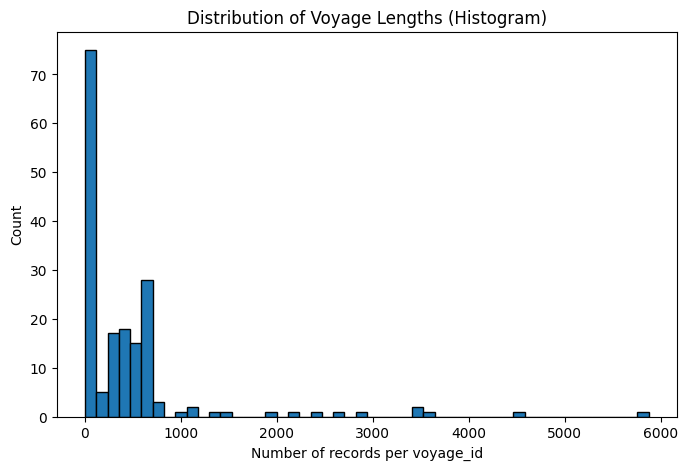

In [38]:
import matplotlib.pyplot as plt

# 計算每個 voyage_id 的長度
voyage_lengths = df_filtered.groupby("voyage_id").size()

plt.figure(figsize=(8,5))
plt.hist(voyage_lengths, bins=50, edgecolor="black")
plt.xlabel("Number of records per voyage_id")
plt.ylabel("Count")
plt.title("Distribution of Voyage Lengths (Histogram)")
plt.show()


In [39]:
df_filtered.groupby("voyage_id").size().value_counts()

2      36
4       7
6       5
326     3
8       3
       ..
626     1
700     1
592     1
460     1
168     1
Name: count, Length: 109, dtype: int64

In [41]:
df_filtered.groupby("voyage_id")["CreateTime"].is_monotonic_increasing.all()


np.True_